This notebook performs the error propagation for J0437-4715 and plot the position translation between the original and updated epochs. Special case of posn_error_all.ipynb

In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time 
from astropy.time import Time

%matplotlib inline

In [9]:
# First write a script to make such a plot for a single pulsar, choose a fun one :)
# PSR J0437-4715

# define necessary variables as strings 
ra = Angle('04:37:15.8961737', unit = u.hourangle)
dec = Angle('-47:15:09.110714', unit = u.deg)
pmra = u.Quantity('+121.4385', u.mas/u.yr)
pmdec = u.Quantity('-71.4754', u.mas/u.yr)
posepoch = Time(54500.00, format='mjd').jyear

psr = SkyCoord(ra= '04:37:15.8961737', dec= '-47:15:09.110714', unit= (u.hourangle, u.deg), frame = 'icrs', pm_ra_cosdec= pmra, pm_dec= pmdec)

# instantiate pos/pm errors as angle objects of the proper 
ra_err_str = '6.0e-07'
dec_err_str = '7.0e-06'
pmra_err_str = '2.0e-03'
pmdec_err_str = '2.0e-03'

err_strings = [ra_err_str, dec_err_str, pmra_err_str, pmdec_err_str]
errs = [0,0,0,0]
for i in range(len(err_strings)):
    if 'e' in err_strings[i]:
        base, exp = err_strings[i].split('e')
        base = float(base)
        exp = float(exp)
        num = base*(10**exp)
        errs[i] = Angle(num, unit = u.mas) /u.yr
    else:
        num = float(err_strings[i])
        pmdec_err = Angle(num, unit = u.mas) / u.yr
ra_err = errs[0] * u.yr
dec_err = errs[1] * u.yr
pmra_err = errs[2]
pmdec_err = errs[3]

plotting_pmdec = psr.pm_dec.to_value(u.deg/u.yr) 
plotting_pmra = psr.pm_ra_cosdec.to_value(u.deg/u.yr) 
plotting_ra = psr.ra.value
plotting_dec = psr.dec.value

Define necessary quantities to perform translation, add errors in quadrature

In [17]:
dr2epoch = Time('2015.5', format='jyear').jyear
dr3epoch = Time('2016.0', format='jyear').jyear
epoch_diff_dr2 = (dr2epoch.tolist() * u.yr) - (posepoch.tolist() * u.yr)
epoch_diff_dr3 = (dr3epoch.tolist() * u.yr) - (posepoch.tolist() * u.yr)

# pm times the time diff ----------------------------------
# dr2 
prop2ra = psr.pm_ra_cosdec * epoch_diff_dr2
prop2dec = psr.pm_dec * epoch_diff_dr2
# dr3
prop3ra = psr.pm_ra_cosdec * epoch_diff_dr3
prop3dec = psr.pm_dec * epoch_diff_dr3

# updated epoch positions-----------------------------------
# dr2
prop_ra_dr2 = psr.ra.mas * u.mas + (prop2ra)
prop_dec_dr2 = psr.dec.mas * u.mas + (prop2dec)
# dr3
prop_ra_dr3 = psr.ra.to_value(u.mas) * u.mas + (prop3ra)  
prop_dec_dr3 = psr.dec.to_value(u.mas) * u.mas + (prop3dec)

# propagate error by adding in quadruture --------------------------------------------------------
# dr2
prop_ra_err_dr2 = np.sqrt((ra_err)**2 + (pmra_err*epoch_diff_dr2)**2)
prop_dec_err_dr2 = np.sqrt((dec_err)**2 + (pmdec_err*epoch_diff_dr2)**2)
# dr3
prop_ra_err_dr3 = np.sqrt((ra_err)**2 + (pmra_err*epoch_diff_dr3)**2)
prop_dec_err_dr3 = np.sqrt((dec_err)**2 + (pmdec_err*epoch_diff_dr3)**2)

# define a new skycoord object with the propogated positions -------------------------------------
psr_dr2 = SkyCoord(ra= prop_ra_dr2, dec= prop_dec_dr2, unit= (u.mas, u.mas), frame = 'icrs', pm_ra_cosdec= pmra, pm_dec= pmdec)
psr_dr3 = SkyCoord(ra= prop_ra_dr3, dec= prop_dec_dr3, unit= (u.mas, u.mas), frame = 'icrs', pm_ra_cosdec= pmra, pm_dec= pmdec)

Plot position translation

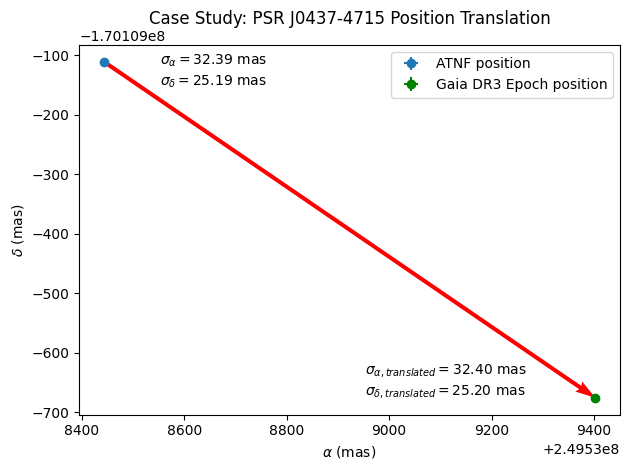

In [18]:
fig = plt.figure(figsize=(6.4, 4.8))
ax1 = fig.add_subplot()

x = np.linspace(psr.ra.to_value(u.mas), psr_dr3.ra.to_value(u.mas) + 10, 10)

ax1.errorbar(psr.ra.to_value(u.mas), psr.dec.to_value(u.mas), yerr= dec_err.to_value(u.mas), xerr= ra_err.to_value(u.mas), fmt= 'o', label= 'ATNF position')
ax1.quiver(psr.ra.to_value(u.mas), psr.dec.to_value(u.mas), prop3ra.value, prop3dec.value, color= 'red', scale = 1, scale_units= 'xy', angles= 'xy')
ax1.errorbar(psr_dr3.ra.to_value(u.mas), psr_dr3.dec.to_value(u.mas), yerr= prop_dec_err_dr3.value, xerr= prop_ra_err_dr3.value, fmt= 'go', ecolor= 'green', label= 'Gaia DR3 Epoch position')
ax1.legend()
ax1.text(psr.ra.to_value(u.mas)+prop3ra.value-850, psr.dec.to_value(u.mas)-5, r'$\sigma_{\alpha}=32.39$ mas')
ax1.text(psr.ra.to_value(u.mas)+prop3ra.value-850, psr.dec.to_value(u.mas)-40, r'$\sigma_{\delta}=25.19$ mas')
ax1.text(psr.ra.to_value(u.mas)+prop3ra.value-450, psr.dec.to_value(u.mas)-525, r'$\sigma_{\alpha, translated}=32.40$ mas')
ax1.text(psr.ra.to_value(u.mas)+prop3ra.value-450, psr.dec.to_value(u.mas)-560, r'$\sigma_{\delta, translated}=25.20$ mas')
ax1.set_title('Case Study: PSR J0437-4715 Position Translation', pad= 15)
ax1.set_xlabel(r'$\alpha$ (mas)')
ax1.set_ylabel(r'$\delta$ (mas)')

fig.tight_layout()